In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import dirichlet
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import ternary

from ensemblecalibration.data.gp_binary import (
    sample_binary_preds_gp,
    rbf_kernel,
    sample_pbar_h0,
    sample_pbar_h1,
    multinomial_label_sampling,
)
from ensemblecalibration.data.multiclass_dirichlet import exp_dirichlet
from ensemblecalibration.utils.helpers import calculate_pbar, sample_function
from ensemblecalibration.utils.plot_functions import plot_heatmap_dirichlet_2D
from ensemblecalibration.utils.projections import project_points2D

## Explore binary predictors synthesized by Gaussian processes

randomly generated functions which will later be used as instance-dependent convex combinations of binary predictors:

In [76]:
# PARAMETERS
N_SAMPLES = 1000
X_BOUND = [0, 1]
KERNEL = rbf_kernel
LIST_BOUNDS_P = [[0, 0.2], [.5, .7]]
DEG = 2

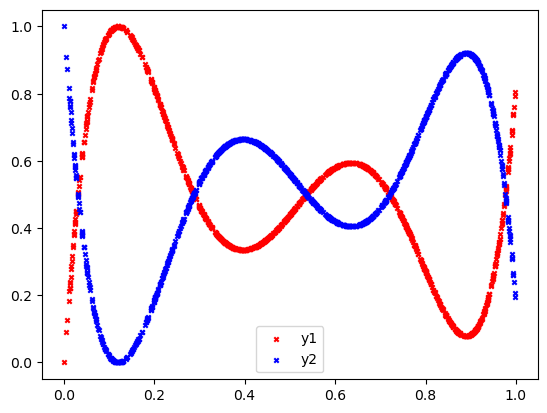

In [77]:
# play around 
x_inst = np.random.uniform(X_BOUND[0], X_BOUND[1], N_SAMPLES)
x_sorted = np.sort(x_inst)
x_inst = x_sorted
# weight functions for the case of having two predictors
y1 = sample_function(x_inst, deg=5)
y2 = 1 - y1

# plot
plt.scatter(x_inst, y1, label='y1', color='red', marker='x', s=10)
plt.scatter(x_inst, y2, label='y2', color='blue', marker='x', s=10)
plt.legend()

For this experiment, we consider the case of binary classification, i.e. $\mathcal{Y}=\{0, 1 \}$, 
and generate predictions $\mathcal{P} = \{\hat{p}^{(1)}, \dots, \hat{p}^{(M)} \}$ where
$$\hat{p}_i: \mathcal{X} \rightarrow (\hat{p}_{i, 0}, \hat{p}_{i, 1}).$$ 

Here, we sample $\hat{p}_{i, 0}$ from a Gaussian process with values in a predefined range $[i_{lower}, i_{upper}]$.

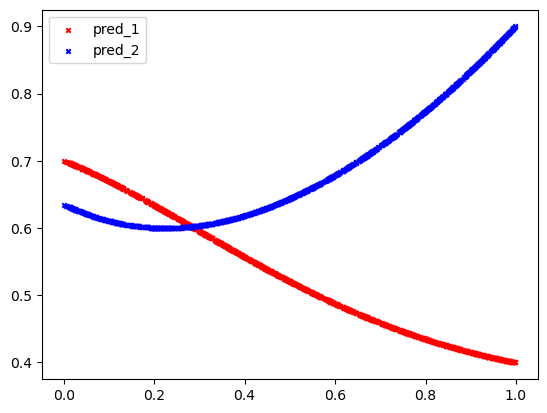

In [78]:
# now look at functions generated by the GP
p_preds = sample_binary_preds_gp(
    x_inst, kernel=rbf_kernel, list_bounds_p=[[0.4, 0.7], [.6, .9]]
)


plt.scatter(x_inst, p_preds[:, 0, 0], label="pred_1", color='red', marker='x', s=10)
plt.scatter(x_inst, p_preds[:, 1, 0], label="pred_2", color='blue', marker='x', s=10)
plt.legend()

We can now sample probabilities from a new predictor $\hat{p}_{\lambda}$ where either the null hypothesis 
$$H_0: \hat{p}_{\lambda}(x) = \sum_{i=1}^M \hat{p}^{(m)}(x)$$
 or the alternative hypothesis
$$H_1: \hat{p}_{\lambda}(x) \neq \sum_{i=1}^M \hat{p}^{(m)}(x)$$
hold.

In [79]:
p_bar_h0_const, weights_h0_const = sample_pbar_h0(x_inst, p_preds=p_preds, x_dep=False, deg=DEG)
p_bar_h0_x_dep, weights_h0_x_dep = sample_pbar_h0(x_inst, p_preds=p_preds, x_dep=True, deg=DEG)
p_bar_h1_s1 = sample_pbar_h1(x_inst, p_preds=p_preds, kernel=KERNEL, setting = 1)
p_bar_h1_s2 = sample_pbar_h1(x_inst, p_preds=p_preds, kernel=KERNEL, setting=2)
p_bar_h1_s3 = sample_pbar_h1(x_inst, p_preds=p_preds, kernel=KERNEL, setting=3)

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/3779985926.py:5: SyntaxWarning: invalid escape sequence '\h'
  ax.scatter(x_inst, p_preds[:, 0, 0], label="$\hat{p}^{(1)}, \hat{p}^{(2)}$", color='black', marker='x', s=2)
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipyk

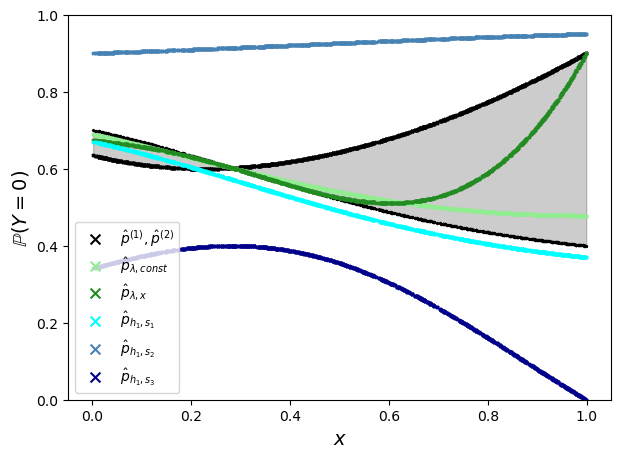

In [80]:
fig, ax = plt.subplots(figsize=(7, 5))
# use viridis colormap
sns.set_palette("viridis", 4) 

ax.scatter(x_inst, p_preds[:, 0, 0], label="$\hat{p}^{(1)}, \hat{p}^{(2)}$", color='black', marker='x', s=2)
ax.scatter(x_inst, p_preds[:, 1, 0],  color='black', marker='x', s=4)
# shade space between p_preds[:,0,0] and p_preds[:,1,0]
ax.fill_between(x_inst, p_preds[:, 0, 0], p_preds[:, 1, 0], color='black', alpha=0.2)
ax.scatter(x_inst, p_bar_h0_const[:, 0], label="$\hat{p}_{\lambda, const}$",  marker='x', s=4,
color="lightgreen")
ax.scatter(x_inst, p_bar_h0_x_dep[:, 0], label="$\hat{p}_{\lambda, x}$", marker='x', s=4, color="forestgreen")
ax.scatter(x_inst, p_bar_h1_s1[:,0], label="$\hat{p}_{h_1, s_1}$", marker='x', s=4, color="cyan")
ax.scatter(x_inst, p_bar_h1_s2[:,0],  label="$\hat{p}_{h_1, s_2}$", marker='x', s=4, color="steelblue")
ax.scatter(x_inst, p_bar_h1_s3[:,0], label="$\hat{p}_{h_1, s_3}$", marker='x', s=4, color="darkblue")
legend = plt.legend()
# x and y axis labels
ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$\mathbb{P}(Y=0)$", fontsize=14)
# set ylim to [0,1]
plt.ylim(0,1)

for handle in legend.legendHandles:
    handle._sizes = [50]

plt.savefig("../figures/gp_setting.png")

In [81]:
y_labels = torch.stack(
        [multinomial_label_sampling(p, tensor=True) for p in torch.unbind(p_bar_h0_x_dep, dim=0)]
    )

## multi-dimensional case
For the multi-dimensional case, we take an appproach of sampling from Dirichlet distributions whose parameters are an instance-dependent function of the instance values.

In [82]:

def sample_dir_params(x_inst: torch.tensor, dir_prior: torch.tensor):
    # sample prior
   # dir_prior = torch.distributions.Dirichlet(torch.ones(n_classes)/n_classes).sample()
    # initialize parameters 
    params_m = torch.zeros((x_inst.shape[0], dir_prior.shape[0]))
    for i in range(dir_prior.shape[0]):
        # instance-dependent parameters
        params_m[:, i] = (dir_prior[i] * dir_prior.shape[0])/.1
    return params_m

def sample_ensemble_predictions(x_inst: torch.tensor, n_ens: int, n_classes: int):
    p_preds = torch.zeros((x_inst.shape[0], n_ens, n_classes))
    # sample prior for all ensemble members
    dir_prior = torch.distributions.Dirichlet(torch.ones(n_classes)).sample()
    for i in range(n_ens):
        dir_params = sample_dir_params(x_inst, dir_prior)
        p_preds[:, i, :] = torch.distributions.Dirichlet(dir_params).sample()
    return p_preds, dir_prior



In [83]:

x_sorted = torch.sort(torch.tensor(x_inst))[0]
p_preds, dir_prior = sample_ensemble_predictions(x_sorted, 5, 3)

In [84]:
# now sample random function for the convex combination
lambda_weights = torch.zeros((x_sorted.shape[0], 5))
for i in range(lambda_weights.shape[1]):
    ivl = (np.random.uniform(0, 10, 2))
    lambda_weights[:,i] = torch.tensor(sample_function(x_sorted, deg=1, ivl=ivl))
# put softmax on top
lambda_weights = torch.nn.functional.softmax(lambda_weights, dim=1)

# now non-instance dependent lambda_weights
lambda_weights_const = torch.zeros((x_sorted.shape[0], 5))
# set all rows to same values, smapled from Dirichlet distribution
lambda_weights_const = torch.distributions.Dirichlet(torch.ones(5)).sample().repeat(x_sorted.shape[0], 1)


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/2730334468.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x_sorted, lambda_weights[:,0], color="darkblue", label="$\lambda_x$")
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/2730334468.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(x_sorted, lambda_weights_const[:,0], color="darkgreen", label="$\lambda_{const}$", linestyle='dashed')


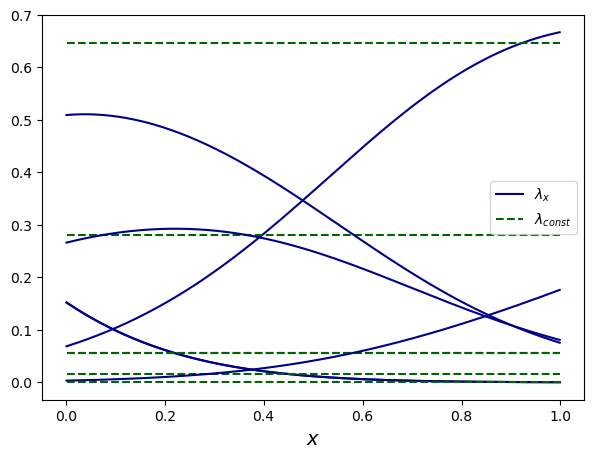

In [95]:
#print(lambda_weights)
#plot
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(x_sorted, lambda_weights[:,0], color="darkblue", label="$\lambda_x$")
ax.plot(x_sorted, lambda_weights_const[:,0], color="darkgreen", label="$\lambda_{const}$", linestyle='dashed')
for i in range(lambda_weights.shape[1]):
    ax.plot(x_sorted, lambda_weights[:,i], color="darkblue")
    ax.plot(x_sorted, lambda_weights_const[:,i], color="darkgreen", linestyle='dashed')
ax.set_xlabel("$x$", fontsize=14)
plt.legend()

plt.savefig("../figures/weights_dirichlet.png")

In [86]:
p_bar = calculate_pbar(lambda_weights, p_preds)
p_bar_const = calculate_pbar(lambda_weights_const, p_preds)

<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/4234007839.py:4: SyntaxWarning: invalid escape sequence '\h'
  ax.scatter(x_sorted[:1000], p_bar[:1000, i], label=f"$\hat{{p}}_{{{i}}}$", marker='x')


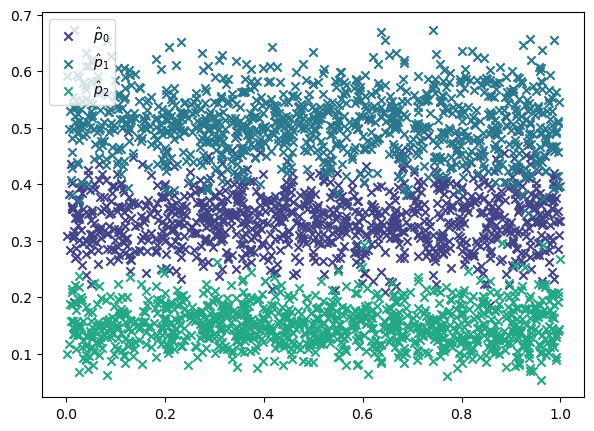

In [87]:
# plot p_bar
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(3):
    ax.scatter(x_sorted[:1000], p_bar[:1000, i], label=f"$\hat{{p}}_{{{i}}}$", marker='x')
ax.legend()

We will now analyse the distribution of the 

<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\{'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\h'
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/1094610205.py:26: SyntaxWarning: invalid escape sequence '\{'
  tax.scatter(list(map(tuple, points)), marker='o', color='red', label='$\{f^{(i)}\}_{i=1}^{10}$')
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/1094610205.py:27: SyntaxWarning: invalid escape sequence '\h'
  tax.scatter(list(map(tuple, [point_pbar])), marker='o', color='blue', label='$\hat{p}_{\lambda(x)}$')
/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_45094/1094610205.py:28: SyntaxWarning: invalid escape sequence '\h'
  tax.scatter(list(map(tuple, [point_pbar_const])), marker='o', color='green', label='$\hat{p}_{\lambda}$')
/U

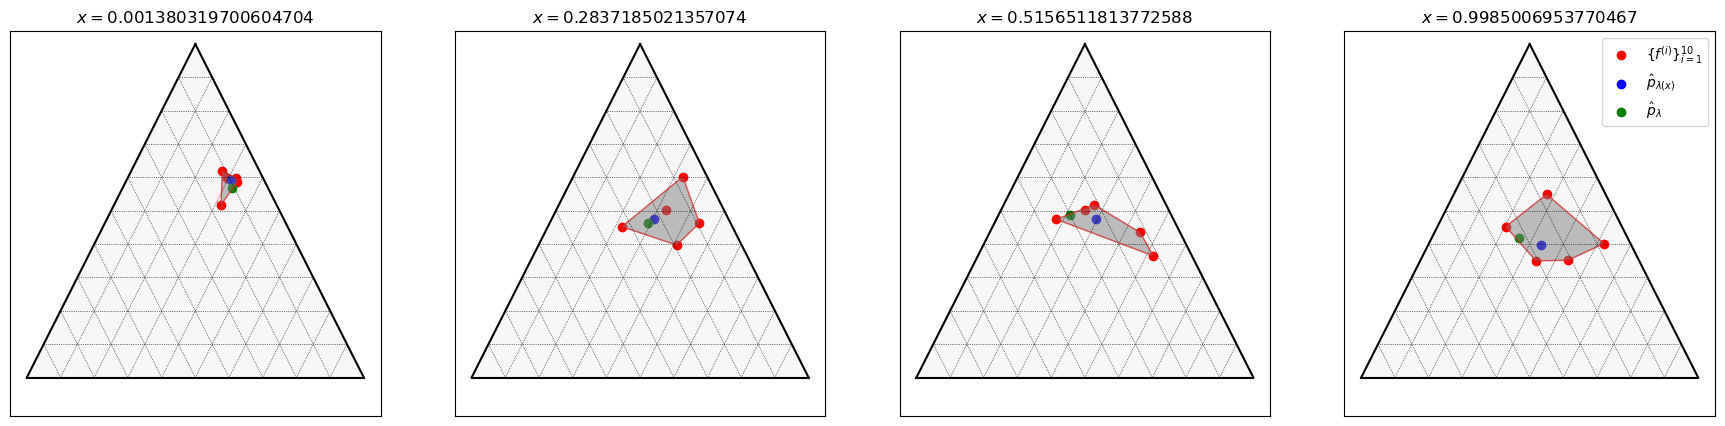

In [88]:
x_eval = [0, 250, 500, 999]

fig, ax = plt.subplots(1, len(x_eval), figsize=(22, 5))
for i, x in enumerate(x_eval):
    tax = ternary.TernaryAxesSubplot(ax=ax[i])
    points = p_preds[x, :, :].detach().numpy()
    point_pbar = p_bar[x, :].detach().numpy()
    point_pbar_const = p_bar_const[x, :].detach().numpy()
    # point_preds = preds[x, :].detach().numpy()

    # Project the 3D simplex points to 2D by dropping the last coordinate
    points_2d = project_points2D(points)

    # Compute the Convex Hull in 2D
    hull = ConvexHull(points_2d)

    # Get the vertices of the convex hull
    hull_vertices = points[hull.vertices]

    # Initialize the ternary plot
    #figure, tax = ternary.figure(scale=1.0)
    tax.boundary()
    tax.gridlines(color="black", multiple=0.1)

    # Plot the points
    tax.scatter(list(map(tuple, points)), marker='o', color='red', label='$\{f^{(i)}\}_{i=1}^{10}$')
    tax.scatter(list(map(tuple, [point_pbar])), marker='o', color='blue', label='$\hat{p}_{\lambda(x)}$')
    tax.scatter(list(map(tuple, [point_pbar_const])), marker='o', color='green', label='$\hat{p}_{\lambda}$')
   # tax.scatter(list(map(tuple, [point_preds])), marker='o', color='green', label='preds')
    # Create a polygon patch
    polygon = Polygon(list(map(tuple,project_points2D(hull_vertices))), closed=True, color='grey', alpha=0.5)
    tax.get_axes().add_patch(polygon)

    # Plot the boundary edges from the Convex Hull
    for simplex in hull.simplices:
        point1 = tuple(points[simplex[0]])
        point2 = tuple(points[simplex[1]])
        tax.line(point1, point2, linewidth=1.0, color='red', alpha=0.5)

    # Customize the plot
    x_val = x_inst[x]
    tax.set_title(f"$x = {{{x_val}}}$")
    # remove outer axes
    tax.clear_matplotlib_ticks()

    # Show the plot
    plt.legend()

plt.savefig("../figures/dirichlet_ensemble_setting.png")